In [54]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pprint as pprint
import datetime as dt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [26]:
# Create our session (link) from Python to the DB
session  = Session(engine)

In [40]:
# Display the Station table columns
first_row_station = session.query(Station).first()
first_row_station.__dict__



{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe7111aec70>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

In [157]:
# Display the Measurement table columns
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe6c0396970>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

# Exploratory Precipitation Analysis

In [51]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"This is the most recent date in the Measurement data set {recent_date}")

This is the most recent date in the Measurement data set ('2017-08-23',)


This is one year ago '2016-08-23'


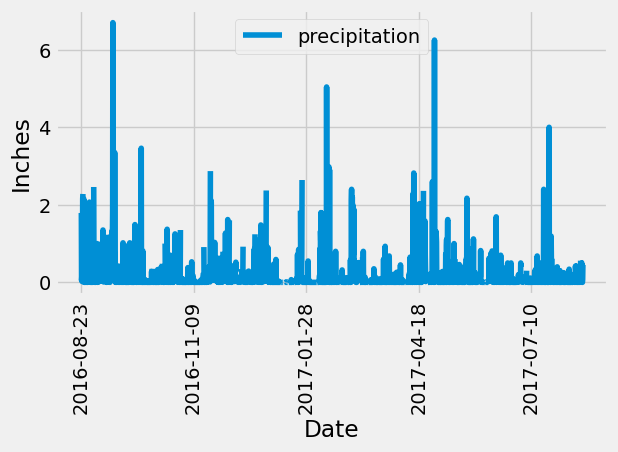

In [282]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"This is one year ago '{one_year_ago}'")

# Perform a query to retrieve the data and precipitation scores
measure_year_ago = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23')

# Save the query results as a Pandas DataFrame and set the index to the date column
df_measure_query = pd.DataFrame(measure_year_ago).set_index("date")

# Sort the dataframe by date
df_measure_query_date = df_measure_query.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df_measure_query_date.plot(xlabel="Date", ylabel= "Inches",rot=90)
plt.legend(["precipitation"])
plt.tight_layout()
plt.show()



In [155]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_measure_query_date.rename(columns={"prcp":"Percipitation"},inplace=True)
df_measure_query_date.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [220]:
# Display the Station table columns
first_row_station = session.query(Measurement).first()
first_row_station.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe6c0396970>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [183]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).distinct().count()

9

In [219]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).all()

most_active = "USC00519281"


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [247]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_item_list = [] 
station_item_list = session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

print(f"The {station_item_list[0][0]} has a min {station_item_list[0][1]} and a max of {station_item_list[0][2]} and an average of {round(station_item_list[0][3],2)} on temperature.")

The USC00519281 has a min 54.0 and a max of 85.0 and an average of 71.66 on temperature.


In [253]:
#Getting the latest date from the most active to have a reference point on obtaining the last 12 months
date_recent = session.query(Measurement.date).\
                filter(Measurement.station == "USC00519281").\
                order_by(Measurement.date.desc()).first()
print(date_recent[0])


2017-08-18


In [264]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_station_past_year = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date <= date_recent[0]).\
    filter(Measurement.date >= (dt.date(int(date_recent[0][0:4]),int(date_recent[0][6]),int(date_recent[0][8:10])) - dt.timedelta(days=365))).\
    all()

Text(0.5, 0, 'Temperature')

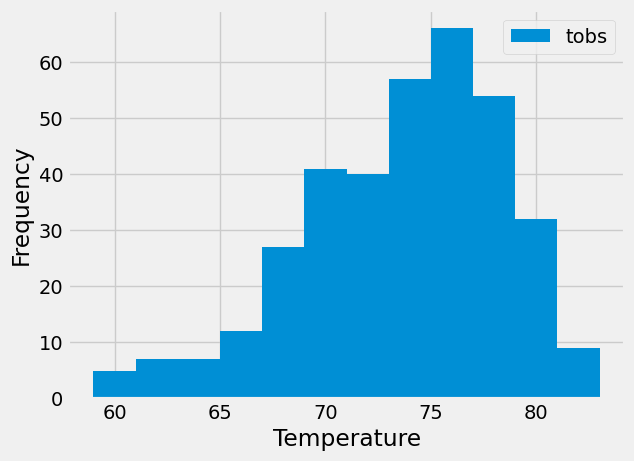

In [271]:
df_active_station = pd.DataFrame(active_station_past_year).set_index("date")
df_active_station.head()
df_active_station.plot.hist(bins=12).set_xlabel("Temperature")

# Close session

In [275]:
# Close Session
session.close()